In [13]:
import numpy as np
import sys
print(sys.executable)
from mpl_toolkits import mplot3d


import deepxde as dde

# 用于绘图
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

a = 1
b = 2
k_r = 1.5
k_i = 1
v_1 = 1
v_2 = 1
v_3 = 1
c = np.log((a * a * v_1 + b * b * v_2 + a * b * v_3 + a * b * v_3) / ((2 * k_r) * (2 * k_r)))
print(sys.executable)
#周期性边界条件
x_lower = -10
x_upper = 10
t_lower = -2
t_upper =2

# 创建 2D 域（用于绘图和输入）
x = np.linspace(x_lower, x_upper, 512)
t = np.linspace(t_lower, t_upper, 402)
X, T = np.meshgrid(x, t)

# 整个域变平
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# 空间和时间域/几何（对于 deepxde 模型）
space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)
# 损失的“物理信息”部分


def pde(x,y):
    """
    INPUTS:
        x: x[:,0] 是 x 坐标
           x[:,1] 是 t 坐标
        y: 网络输出，在这种情况下:
            y[:,0] 是 u(x,t) 实部
            y[:,1] 是 v(x,t) 虚部
    OUTPUT:
        标准形式的 pde，即必须为零的东西
    """
    
    
    u1 = y[:, 0:1]
    v1 = y[:, 1:2]
    u2 = y[:, 2:3]
    v2 = y[:, 3:4]
    

    # 在'jacobian'中，i 是输出分量，j 是输入分量
    u1_t = dde.grad.jacobian(y, x, i=0, j=1)
    v1_t = dde.grad.jacobian(y, x, i=1, j=1)
    u2_t = dde.grad.jacobian(y, x, i=2, j=1)
    v2_t = dde.grad.jacobian(y, x, i=3, j=1)

    u1_x = dde.grad.jacobian(y, x, i=0, j=0)
    v1_x = dde.grad.jacobian(y, x, i=1, j=0)
    u2_x = dde.grad.jacobian(y, x, i=2, j=0)
    v2_x = dde.grad.jacobian(y, x, i=3, j=0)

    # 在“hessian”中，i 和 j 都是输入分量。 （Hessian 原则上可以是 d^2y/dxdt、d^2y/d^2x 等）
    # 输出组件由“组件”选择
    u1_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v1_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    u2_xx = dde.grad.hessian(y, x, component=2, i=0, j=0)
    v2_xx = dde.grad.hessian(y, x, component=3, i=0, j=0)

    #f_u = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
    #f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u

    r1=1
    r2=2
    r3=-1
    r4=0
    beta=1
    
    f_u1 = (
            v1_t + u1_xx
        + r1*u1*(u1**2 + v1**2) + r2*u1*(u2**2 + v2**2) + r3*(u1*(u2**2 - v2**2) + 2*u2*v1*v2) + r4*(u2*(u1**2 - v1**2) + 2*u1*v1*v2)
    )

    f_v1 = (
            -u1_t + v1_xx
        + r1*v1*(u1**2 + v1**2) + r2*v1*(u2**2 + v2**2) - r3*(v1*(u2**2 - v2**2) - 2*u1*u2*v2) - r4*(v2*(u1**2 - v1**2) - 2*u1*u2*v1)
    )

    f_u2 = (
            v2_t + beta*u2_xx
        + r1*u2*(u2**2 + v2**2) + r2*u2*(u1**2 + v1**2) + r3*(u2*(u1**2 - v1**2) + 2*u1*v2*v1) + r4*(u1*(u2**2 - v2**2) + 2*u2*v2*v1)
    )

    f_v2 = (
            -u2_t + beta*v2_xx
        + r1*v2*(u2**2 + v2**2) + r2*v2*(u1**2 + v1**2) - r3*(v2*(u1**2 - v1**2) - 2*u2*u1*v1) - r4*(v1*(u2**2 - v2**2) - 2*u2*u1*v2)
    )
    
    return [
        f_u1, f_v1, f_u2, f_v2,
        #f_u1x, f_u1t,
        #f_v1x, f_v1t,
        #f_u2x, f_u2t,
        #f_v2x, f_v2t
    ]
 # 边界条件和初始条件

# 周期性边界条件
bc_u1_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u1_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v1_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v1_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)
bc_u2_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=2
)
bc_u2_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=2
)
bc_v2_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=3
)
bc_v2_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=3
)
#(e^c=...)
# 初始条件
def boundary_l(x, on_boundary):
    return on_boundary and np.isclose(x[0], -1)

k1=1.5
k2=1
l1=1.5
l2=-1
nf1=0
nf2=0
ng1=0
ng2=0
k=complex(k1,-k2)
kk=k.conjugate()
l=complex(l1,-l2)
ll=l.conjugate()
nf=complex(nf1,-nf2)
nff=nf.conjugate()
ng=complex(ng1,-ng2)
ngg=ng.conjugate()



def init_cond_u1(x):
    f=np.exp((0-1j)*(k**2)*x[:,1:2] + k*x[:,0:1] + nf)
    ff=f.conjugate()
    g=np.exp((0-1j)*(l**2)*x[:,1:2] + l*x[:,0:1] + ng)
    gg=g.conjugate()
    phi1=1+2*f*ff/((k+kk)**2)
    phi2=1+2*g*gg/((l+ll)**2)
    f1=f.real
    f2=-f.imag
    g1=g.real
    g2=-g.imag
    
    result=f1/phi1 +g1/phi2
    
    
    #result=( (1/phi1)*(np.exp(-2*k1*k2*x[:,1:2] + k1*x[:,0:1] + nf1) * np.cos((-k1**2+k2**2)*x[:,1:2] - k2*x[:,0:1] - nf2))
     #       + (1/phi2)*(np.exp(-2*l1*l2*x[:,1:2] + l1*x[:,0:1] + ng1) * np.cos((-l1**2+l2**2)*x[:,1:2] - l2*x[:,0:1] - ng2))
     #      )
    return result
    
def init_cond_u2(x):
    f=np.exp((0-1j)*(k**2)*x[:,1:2] + k*x[:,0:1] + nf)
    ff=f.conjugate()
    g=np.exp((0-1j)*(l**2)*x[:,1:2] + l*x[:,0:1] + ng)
    gg=g.conjugate()
    phi1=1+2*f*ff/((k+kk)**2)
    phi2=1+2*g*gg/((l+ll)**2)
    f1=f.real
    f2=-f.imag
    g1=g.real
    g2=-g.imag
    
    result=f2/phi1 - g2/phi2
    
    #result=( -(1/phi1)*(np.exp(-2*k1*k2*x[:,1:2] + k1*x[:,0:1] + nf1) * np.sin((-k1**2+k2**2)*x[:,1:2] - k2*x[:,0:1] - nf2))
     #       + (1/phi2)*(np.exp(-2*l1*l2*x[:,1:2] + l1*x[:,0:1] + ng1) * np.sin((-l1**2+l2**2)*x[:,1:2] - l2*x[:,0:1] - ng2))
      #     )
    return result

def init_cond_v1(x):
    f=np.exp((0-1j)*(k**2)*x[:,1:2] + k*x[:,0:1] + nf)
    ff=f.conjugate()
    g=np.exp((0-1j)*(l**2)*x[:,1:2] + l*x[:,0:1] + ng)
    gg=g.conjugate()
    phi1=1+2*f*ff/((k+kk)**2)
    phi2=1+2*g*gg/((l+ll)**2)
    f1=f.real
    f2=-f.imag
    g1=g.real
    g2=-g.imag
    
    result= f2/phi1 + g2/phi2
    
    #result=-( (1/phi1)*(np.exp(-2*k1*k2*x[:,1:2] + k1*x[:,0:1] + nf1) * np.sin((-k1**2+k2**2)*x[:,1:2] - k2*x[:,0:1] - nf2))
    #        + (1/phi2)*(np.exp(-2*l1*l2*x[:,1:2] + l1*x[:,0:1] + ng1) * np.sin((-l1**2+l2**2)*x[:,1:2] - l2*x[:,0:1] - ng2))
    #       )
    return result

def init_cond_v2(x):
    f=np.exp((0-1j)*(k**2)*x[:,1:2] + k*x[:,0:1] + nf)
    ff=f.conjugate()
    g=np.exp((0-1j)*(l**2)*x[:,1:2] + l*x[:,0:1] + ng)
    gg=g.conjugate()
    phi1=1+2*f*ff/((k+kk)**2)
    phi2=1+2*g*gg/((l+ll)**2)
    f1=f.real
    f2=-f.imag
    g1=g.real
    g2=-g.imag
    
    result= -f1/phi1 +g1/phi2
    
    #result= ( -(1/phi1)*(np.exp(-2*k1*k2*x[:,1:2] + k1*x[:,0:1] + nf1) * np.cos((-k1**2+k2**2)*x[:,1:2] - k2*x[:,0:1] - nf2))
    #        + (1/phi2)*(np.exp(-2*l1*l2*x[:,1:2] + l1*x[:,0:1] + ng1) * np.cos((-l1**2+l2**2)*x[:,1:2] - l2*x[:,0:1] - ng2))
    #       )
    return result

ic_u1 = dde.IC(geomtime, init_cond_u1, lambda _, on_initial: on_initial, component=0)
ic_v1 = dde.IC(geomtime, init_cond_v1, lambda _, on_initial: on_initial, component=1)
ic_u2 = dde.IC(geomtime, init_cond_u2, lambda _, on_initial: on_initial, component=2)
ic_v2 = dde.IC(geomtime, init_cond_v2, lambda _, on_initial: on_initial, component=3)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u1_0, bc_u1_1, bc_v1_0, bc_v1_1,bc_u2_0, bc_u2_1, bc_v2_0, bc_v2_1, ic_u1, ic_v1,ic_u2, ic_v2],
    num_domain=10000,
    num_boundary=20,
    num_initial=200,
    train_distribution="pseudo",
)

allow_unused=True
# 网络架构
net = dde.maps.FNN([2] + [100] * 5 + [4], "silu", "Glorot normal")

model = dde.Model(data, net)

C:\tools\Anaconda3\python.exe
C:\tools\Anaconda3\python.exe


In [14]:
model.compile("adam", lr=1e-3, loss="MSE")
model.train(epochs=3000, display_every=10)

Compiling model...
Building feed-forward neural network...
'build' took 0.046322 s

'compile' took 3.930232 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
0         [6.47e-05, 2.37e-05, 1.93e-05, 5.92e-05, 1.11e-02, 5.35e-05, 1.77e-02, 2.21e-04, 5.02e-03, 5.15e-04, 4.45e-02, 1.88e-04, 1.21e-01, 6.39e-02, 6.14e-02, 1.08e-01]    [6.47e-05, 2.37e-05, 1.93e-05, 5.92e-05, 1.11e-02, 5.35e-05, 1.77e-02, 2.21e-04, 5.02e-03, 5.15e-04, 4.45e-02, 1.88e-04, 1.21e-01, 6.39e-02, 6.14e-02, 1.08e-01]    []  
10        [9.68e-05, 5.02e-04, 5.99e-05, 1.10e-04, 1.13e-04, 3.71e-05, 9.02e-04, 3.34e-04, 4.15e-04, 1.01e-04, 7.38e-03, 2.85e-05, 9.66e-02, 6.15e-02, 

230       [6.33e-03, 4.93e-03, 6.60e-03, 6.35e-03, 1.56e-05, 1.07e-05, 6.19e-05, 2.48e-04, 4.66e-05, 9.70e-06, 1.01e-04, 3.10e-05, 2.17e-02, 1.55e-02, 1.75e-02, 1.85e-02]    [6.33e-03, 4.93e-03, 6.60e-03, 6.35e-03, 1.56e-05, 1.07e-05, 6.19e-05, 2.48e-04, 4.66e-05, 9.70e-06, 1.01e-04, 3.10e-05, 2.17e-02, 1.55e-02, 1.75e-02, 1.85e-02]    []  
240       [7.93e-03, 5.88e-03, 6.85e-03, 7.72e-03, 2.23e-05, 3.46e-05, 6.14e-05, 2.03e-04, 7.72e-05, 1.62e-05, 1.24e-04, 1.05e-05, 1.80e-02, 1.34e-02, 1.52e-02, 1.65e-02]    [7.93e-03, 5.88e-03, 6.85e-03, 7.72e-03, 2.23e-05, 3.46e-05, 6.14e-05, 2.03e-04, 7.72e-05, 1.62e-05, 1.24e-04, 1.05e-05, 1.80e-02, 1.34e-02, 1.52e-02, 1.65e-02]    []  
250       [7.16e-03, 6.54e-03, 6.85e-03, 7.30e-03, 6.17e-06, 1.78e-05, 3.00e-05, 1.42e-04, 7.10e-05, 2.99e-06, 3.17e-05, 3.98e-05, 1.57e-02, 1.23e-02, 1.36e-02, 1.55e-02]    [7.16e-03, 6.54e-03, 6.85e-03, 7.30e-03, 6.17e-06, 1.78e-05, 3.00e-05, 1.42e-04, 7.10e-05, 2.99e-06, 3.17e-05, 3.98e-05, 1.57e-02, 1.23e-02,

470       [6.37e-03, 6.24e-03, 6.60e-03, 6.13e-03, 1.13e-03, 4.69e-05, 3.61e-05, 1.47e-04, 7.25e-06, 5.44e-05, 1.01e-03, 5.26e-05, 6.16e-03, 7.65e-03, 5.57e-03, 6.81e-03]    [6.37e-03, 6.24e-03, 6.60e-03, 6.13e-03, 1.13e-03, 4.69e-05, 3.61e-05, 1.47e-04, 7.25e-06, 5.44e-05, 1.01e-03, 5.26e-05, 6.16e-03, 7.65e-03, 5.57e-03, 6.81e-03]    []  
480       [5.72e-03, 4.82e-03, 5.36e-03, 5.20e-03, 4.33e-05, 3.45e-04, 1.18e-04, 1.92e-04, 4.53e-05, 1.28e-04, 4.08e-04, 2.12e-04, 8.60e-03, 6.63e-03, 5.27e-03, 7.84e-03]    [5.72e-03, 4.82e-03, 5.36e-03, 5.20e-03, 4.33e-05, 3.45e-04, 1.18e-04, 1.92e-04, 4.53e-05, 1.28e-04, 4.08e-04, 2.12e-04, 8.60e-03, 6.63e-03, 5.27e-03, 7.84e-03]    []  
490       [5.49e-03, 4.26e-03, 4.72e-03, 5.45e-03, 4.88e-04, 2.16e-04, 1.19e-04, 4.63e-05, 9.90e-05, 2.37e-06, 1.43e-03, 9.78e-05, 5.60e-03, 6.39e-03, 5.86e-03, 5.89e-03]    [5.49e-03, 4.26e-03, 4.72e-03, 5.45e-03, 4.88e-04, 2.16e-04, 1.19e-04, 4.63e-05, 9.90e-05, 2.37e-06, 1.43e-03, 9.78e-05, 5.60e-03, 6.39e-03,

710       [3.98e-03, 3.50e-03, 3.67e-03, 3.89e-03, 2.32e-05, 4.09e-05, 3.31e-06, 5.08e-05, 1.55e-05, 7.46e-06, 1.38e-05, 9.14e-06, 2.94e-03, 2.80e-03, 2.50e-03, 2.82e-03]    [3.98e-03, 3.50e-03, 3.67e-03, 3.89e-03, 2.32e-05, 4.09e-05, 3.31e-06, 5.08e-05, 1.55e-05, 7.46e-06, 1.38e-05, 9.14e-06, 2.94e-03, 2.80e-03, 2.50e-03, 2.82e-03]    []  
720       [3.91e-03, 3.45e-03, 3.64e-03, 3.80e-03, 2.35e-05, 3.93e-05, 2.93e-06, 5.01e-05, 1.32e-05, 8.17e-06, 1.40e-05, 1.01e-05, 2.85e-03, 2.73e-03, 2.47e-03, 2.74e-03]    [3.91e-03, 3.45e-03, 3.64e-03, 3.80e-03, 2.35e-05, 3.93e-05, 2.93e-06, 5.01e-05, 1.32e-05, 8.17e-06, 1.40e-05, 1.01e-05, 2.85e-03, 2.73e-03, 2.47e-03, 2.74e-03]    []  
730       [3.88e-03, 3.39e-03, 3.62e-03, 3.75e-03, 2.61e-05, 3.66e-05, 3.52e-06, 4.88e-05, 1.44e-05, 9.03e-06, 1.61e-05, 1.12e-05, 2.75e-03, 2.65e-03, 2.42e-03, 2.64e-03]    [3.88e-03, 3.39e-03, 3.62e-03, 3.75e-03, 2.61e-05, 3.66e-05, 3.52e-06, 4.88e-05, 1.44e-05, 9.03e-06, 1.61e-05, 1.12e-05, 2.75e-03, 2.65e-03,

950       [2.75e-03, 2.48e-03, 2.53e-03, 2.79e-03, 1.44e-05, 3.48e-05, 1.24e-05, 2.82e-05, 9.56e-05, 1.67e-05, 6.21e-05, 1.89e-05, 1.85e-03, 1.71e-03, 1.72e-03, 1.70e-03]    [2.75e-03, 2.48e-03, 2.53e-03, 2.79e-03, 1.44e-05, 3.48e-05, 1.24e-05, 2.82e-05, 9.56e-05, 1.67e-05, 6.21e-05, 1.89e-05, 1.85e-03, 1.71e-03, 1.72e-03, 1.70e-03]    []  
960       [3.53e-03, 2.63e-03, 2.68e-03, 3.66e-03, 1.21e-04, 3.57e-05, 2.45e-05, 2.81e-05, 3.07e-05, 1.49e-05, 1.37e-05, 1.86e-05, 1.54e-03, 1.42e-03, 1.55e-03, 1.30e-03]    [3.53e-03, 2.63e-03, 2.68e-03, 3.66e-03, 1.21e-04, 3.57e-05, 2.45e-05, 2.81e-05, 3.07e-05, 1.49e-05, 1.37e-05, 1.86e-05, 1.54e-03, 1.42e-03, 1.55e-03, 1.30e-03]    []  
970       [2.99e-03, 2.78e-03, 2.77e-03, 3.15e-03, 2.04e-04, 2.41e-05, 1.40e-05, 3.85e-05, 5.06e-04, 1.01e-04, 5.18e-04, 2.95e-05, 1.66e-03, 1.92e-03, 2.00e-03, 1.55e-03]    [2.99e-03, 2.78e-03, 2.77e-03, 3.15e-03, 2.04e-04, 2.41e-05, 1.40e-05, 3.85e-05, 5.06e-04, 1.01e-04, 5.18e-04, 2.95e-05, 1.66e-03, 1.92e-03,

1190      [2.06e-03, 1.98e-03, 1.86e-03, 2.19e-03, 1.37e-04, 4.42e-05, 3.45e-06, 2.85e-05, 1.52e-04, 1.19e-05, 2.78e-05, 7.72e-06, 1.23e-03, 1.30e-03, 1.30e-03, 1.11e-03]    [2.06e-03, 1.98e-03, 1.86e-03, 2.19e-03, 1.37e-04, 4.42e-05, 3.45e-06, 2.85e-05, 1.52e-04, 1.19e-05, 2.78e-05, 7.72e-06, 1.23e-03, 1.30e-03, 1.30e-03, 1.11e-03]    []  
1200      [2.10e-03, 1.97e-03, 1.84e-03, 2.22e-03, 1.54e-05, 3.34e-05, 7.18e-06, 1.99e-05, 6.39e-05, 1.19e-05, 1.22e-05, 7.58e-06, 1.03e-03, 1.10e-03, 1.16e-03, 9.23e-04]    [2.10e-03, 1.97e-03, 1.84e-03, 2.22e-03, 1.54e-05, 3.34e-05, 7.18e-06, 1.99e-05, 6.39e-05, 1.19e-05, 1.22e-05, 7.58e-06, 1.03e-03, 1.10e-03, 1.16e-03, 9.23e-04]    []  
1210      [2.41e-03, 2.06e-03, 1.92e-03, 2.54e-03, 1.30e-04, 3.54e-05, 1.07e-05, 2.62e-05, 8.46e-05, 1.14e-05, 3.21e-06, 6.83e-06, 8.65e-04, 1.02e-03, 1.10e-03, 7.27e-04]    [2.41e-03, 2.06e-03, 1.92e-03, 2.54e-03, 1.30e-04, 3.54e-05, 1.07e-05, 2.62e-05, 8.46e-05, 1.14e-05, 3.21e-06, 6.83e-06, 8.65e-04, 1.02e-03,

1430      [1.79e-03, 1.69e-03, 1.56e-03, 1.83e-03, 1.48e-04, 2.13e-05, 4.64e-05, 3.17e-05, 1.92e-04, 8.32e-06, 3.81e-06, 3.03e-06, 6.63e-04, 8.55e-04, 9.25e-04, 5.69e-04]    [1.79e-03, 1.69e-03, 1.56e-03, 1.83e-03, 1.48e-04, 2.13e-05, 4.64e-05, 3.17e-05, 1.92e-04, 8.32e-06, 3.81e-06, 3.03e-06, 6.63e-04, 8.55e-04, 9.25e-04, 5.69e-04]    []  
1440      [1.95e-03, 1.73e-03, 1.61e-03, 2.02e-03, 2.34e-06, 2.09e-05, 6.88e-06, 3.03e-05, 3.39e-05, 7.37e-06, 5.83e-06, 2.48e-06, 5.56e-04, 8.03e-04, 8.49e-04, 4.81e-04]    [1.95e-03, 1.73e-03, 1.61e-03, 2.02e-03, 2.34e-06, 2.09e-05, 6.88e-06, 3.03e-05, 3.39e-05, 7.37e-06, 5.83e-06, 2.48e-06, 5.56e-04, 8.03e-04, 8.49e-04, 4.81e-04]    []  
1450      [1.77e-03, 1.72e-03, 1.57e-03, 1.82e-03, 1.18e-04, 3.88e-05, 3.72e-05, 3.41e-05, 2.02e-05, 1.17e-05, 2.92e-05, 1.08e-05, 7.79e-04, 9.14e-04, 9.37e-04, 7.12e-04]    [1.77e-03, 1.72e-03, 1.57e-03, 1.82e-03, 1.18e-04, 3.88e-05, 3.72e-05, 3.41e-05, 2.02e-05, 1.17e-05, 2.92e-05, 1.08e-05, 7.79e-04, 9.14e-04,

1670      [1.84e-03, 1.56e-03, 1.48e-03, 1.81e-03, 7.64e-06, 2.31e-05, 1.94e-05, 5.60e-05, 1.31e-04, 7.60e-06, 9.26e-06, 2.91e-06, 4.19e-04, 5.88e-04, 6.09e-04, 3.91e-04]    [1.84e-03, 1.56e-03, 1.48e-03, 1.81e-03, 7.64e-06, 2.31e-05, 1.94e-05, 5.60e-05, 1.31e-04, 7.60e-06, 9.26e-06, 2.91e-06, 4.19e-04, 5.88e-04, 6.09e-04, 3.91e-04]    []  
1680      [1.77e-03, 1.78e-03, 1.63e-03, 1.73e-03, 1.27e-04, 1.19e-05, 1.30e-05, 4.90e-05, 4.84e-05, 1.71e-05, 3.91e-06, 7.46e-06, 5.24e-04, 6.76e-04, 6.98e-04, 5.22e-04]    [1.77e-03, 1.78e-03, 1.63e-03, 1.73e-03, 1.27e-04, 1.19e-05, 1.30e-05, 4.90e-05, 4.84e-05, 1.71e-05, 3.91e-06, 7.46e-06, 5.24e-04, 6.76e-04, 6.98e-04, 5.22e-04]    []  
1690      [1.89e-03, 1.58e-03, 1.43e-03, 1.78e-03, 1.41e-05, 7.59e-05, 1.28e-04, 9.54e-05, 1.87e-04, 8.16e-06, 2.02e-05, 3.58e-06, 8.67e-04, 9.42e-04, 8.17e-04, 8.62e-04]    [1.89e-03, 1.58e-03, 1.43e-03, 1.78e-03, 1.41e-05, 7.59e-05, 1.28e-04, 9.54e-05, 1.87e-04, 8.16e-06, 2.02e-05, 3.58e-06, 8.67e-04, 9.42e-04,

1910      [1.58e-03, 1.40e-03, 1.32e-03, 1.51e-03, 1.16e-05, 6.84e-06, 1.45e-04, 6.18e-05, 6.95e-05, 2.27e-05, 2.41e-05, 9.98e-06, 3.77e-04, 5.84e-04, 5.79e-04, 3.81e-04]    [1.58e-03, 1.40e-03, 1.32e-03, 1.51e-03, 1.16e-05, 6.84e-06, 1.45e-04, 6.18e-05, 6.95e-05, 2.27e-05, 2.41e-05, 9.98e-06, 3.77e-04, 5.84e-04, 5.79e-04, 3.81e-04]    []  
1920      [1.47e-03, 1.35e-03, 1.22e-03, 1.37e-03, 2.91e-04, 7.53e-05, 2.37e-05, 7.58e-05, 1.21e-03, 1.85e-05, 2.31e-05, 8.42e-06, 5.65e-04, 7.04e-04, 6.49e-04, 6.32e-04]    [1.47e-03, 1.35e-03, 1.22e-03, 1.37e-03, 2.91e-04, 7.53e-05, 2.37e-05, 7.58e-05, 1.21e-03, 1.85e-05, 2.31e-05, 8.42e-06, 5.65e-04, 7.04e-04, 6.49e-04, 6.32e-04]    []  
1930      [1.58e-03, 1.52e-03, 1.47e-03, 1.53e-03, 2.82e-05, 1.85e-05, 7.07e-06, 6.63e-05, 1.99e-04, 1.86e-05, 5.11e-06, 8.11e-06, 3.27e-04, 4.85e-04, 4.87e-04, 3.11e-04]    [1.58e-03, 1.52e-03, 1.47e-03, 1.53e-03, 2.82e-05, 1.85e-05, 7.07e-06, 6.63e-05, 1.99e-04, 1.86e-05, 5.11e-06, 8.11e-06, 3.27e-04, 4.85e-04,

2150      [1.48e-03, 1.29e-03, 1.23e-03, 1.38e-03, 2.47e-06, 2.38e-06, 4.23e-06, 3.85e-05, 1.32e-05, 1.14e-06, 8.70e-06, 1.89e-05, 2.53e-04, 4.19e-04, 4.00e-04, 2.96e-04]    [1.48e-03, 1.29e-03, 1.23e-03, 1.38e-03, 2.47e-06, 2.38e-06, 4.23e-06, 3.85e-05, 1.32e-05, 1.14e-06, 8.70e-06, 1.89e-05, 2.53e-04, 4.19e-04, 4.00e-04, 2.96e-04]    []  
2160      [1.42e-03, 1.19e-03, 1.18e-03, 1.30e-03, 4.86e-05, 4.63e-05, 1.09e-04, 8.89e-05, 1.28e-04, 1.31e-05, 3.53e-05, 1.16e-05, 3.15e-04, 4.28e-04, 3.84e-04, 3.12e-04]    [1.42e-03, 1.19e-03, 1.18e-03, 1.30e-03, 4.86e-05, 4.63e-05, 1.09e-04, 8.89e-05, 1.28e-04, 1.31e-05, 3.53e-05, 1.16e-05, 3.15e-04, 4.28e-04, 3.84e-04, 3.12e-04]    []  
2170      [1.38e-03, 1.27e-03, 1.19e-03, 1.28e-03, 4.30e-06, 2.62e-06, 5.32e-06, 3.30e-05, 1.65e-05, 4.40e-06, 9.46e-06, 1.51e-05, 4.02e-04, 4.93e-04, 4.64e-04, 4.68e-04]    [1.38e-03, 1.27e-03, 1.19e-03, 1.28e-03, 4.30e-06, 2.62e-06, 5.32e-06, 3.30e-05, 1.65e-05, 4.40e-06, 9.46e-06, 1.51e-05, 4.02e-04, 4.93e-04,

2390      [1.28e-03, 1.11e-03, 1.09e-03, 1.19e-03, 2.40e-06, 3.91e-05, 6.25e-06, 2.79e-05, 1.90e-05, 5.87e-06, 1.33e-05, 2.88e-05, 3.74e-04, 4.05e-04, 3.95e-04, 3.64e-04]    [1.28e-03, 1.11e-03, 1.09e-03, 1.19e-03, 2.40e-06, 3.91e-05, 6.25e-06, 2.79e-05, 1.90e-05, 5.87e-06, 1.33e-05, 2.88e-05, 3.74e-04, 4.05e-04, 3.95e-04, 3.64e-04]    []  
2400      [1.28e-03, 1.29e-03, 1.29e-03, 1.19e-03, 1.23e-05, 2.28e-05, 1.22e-04, 9.71e-05, 6.44e-05, 4.21e-05, 2.27e-05, 1.64e-05, 3.01e-04, 4.57e-04, 4.45e-04, 3.71e-04]    [1.28e-03, 1.29e-03, 1.29e-03, 1.19e-03, 1.23e-05, 2.28e-05, 1.22e-04, 9.71e-05, 6.44e-05, 4.21e-05, 2.27e-05, 1.64e-05, 3.01e-04, 4.57e-04, 4.45e-04, 3.71e-04]    []  
2410      [1.69e-03, 1.20e-03, 1.22e-03, 1.54e-03, 4.37e-05, 4.03e-05, 4.63e-06, 9.87e-05, 1.05e-04, 5.27e-06, 5.47e-05, 1.91e-05, 2.38e-04, 3.48e-04, 2.93e-04, 2.10e-04]    [1.69e-03, 1.20e-03, 1.22e-03, 1.54e-03, 4.37e-05, 4.03e-05, 4.63e-06, 9.87e-05, 1.05e-04, 5.27e-06, 5.47e-05, 1.91e-05, 2.38e-04, 3.48e-04,

2630      [1.20e-03, 9.98e-04, 9.94e-04, 1.05e-03, 3.63e-06, 1.53e-05, 1.16e-06, 3.72e-05, 8.32e-05, 2.55e-06, 1.40e-05, 1.24e-05, 3.59e-04, 4.30e-04, 3.90e-04, 4.18e-04]    [1.20e-03, 9.98e-04, 9.94e-04, 1.05e-03, 3.63e-06, 1.53e-05, 1.16e-06, 3.72e-05, 8.32e-05, 2.55e-06, 1.40e-05, 1.24e-05, 3.59e-04, 4.30e-04, 3.90e-04, 4.18e-04]    []  
2640      [1.19e-03, 1.01e-03, 1.02e-03, 1.04e-03, 3.40e-06, 4.23e-06, 1.71e-06, 2.46e-05, 7.06e-06, 3.04e-06, 1.20e-05, 1.38e-05, 1.82e-04, 3.05e-04, 2.85e-04, 2.08e-04]    [1.19e-03, 1.01e-03, 1.02e-03, 1.04e-03, 3.40e-06, 4.23e-06, 1.71e-06, 2.46e-05, 7.06e-06, 3.04e-06, 1.20e-05, 1.38e-05, 1.82e-04, 3.05e-04, 2.85e-04, 2.08e-04]    []  
2650      [1.30e-03, 1.03e-03, 1.08e-03, 1.14e-03, 3.25e-05, 2.87e-05, 1.61e-06, 7.21e-05, 6.86e-05, 1.03e-05, 4.12e-05, 1.07e-05, 1.96e-04, 2.97e-04, 2.58e-04, 1.87e-04]    [1.30e-03, 1.03e-03, 1.08e-03, 1.14e-03, 3.25e-05, 2.87e-05, 1.61e-06, 7.21e-05, 6.86e-05, 1.03e-05, 4.12e-05, 1.07e-05, 1.96e-04, 2.97e-04,

2870      [1.03e-03, 9.89e-04, 1.05e-03, 9.84e-04, 1.39e-04, 2.07e-04, 1.27e-05, 4.26e-04, 1.05e-03, 6.51e-05, 2.14e-04, 1.37e-05, 4.45e-04, 3.50e-04, 4.17e-04, 3.56e-04]    [1.03e-03, 9.89e-04, 1.05e-03, 9.84e-04, 1.39e-04, 2.07e-04, 1.27e-05, 4.26e-04, 1.05e-03, 6.51e-05, 2.14e-04, 1.37e-05, 4.45e-04, 3.50e-04, 4.17e-04, 3.56e-04]    []  
2880      [1.03e-03, 9.29e-04, 9.65e-04, 9.27e-04, 8.20e-06, 7.99e-06, 1.97e-06, 4.34e-05, 7.87e-05, 6.38e-06, 1.02e-05, 7.50e-06, 3.02e-04, 3.79e-04, 3.29e-04, 2.86e-04]    [1.03e-03, 9.29e-04, 9.65e-04, 9.27e-04, 8.20e-06, 7.99e-06, 1.97e-06, 4.34e-05, 7.87e-05, 6.38e-06, 1.02e-05, 7.50e-06, 3.02e-04, 3.79e-04, 3.29e-04, 2.86e-04]    []  
2890      [1.06e-03, 8.96e-04, 9.54e-04, 8.99e-04, 1.38e-05, 8.86e-06, 6.93e-07, 2.26e-05, 3.96e-05, 6.64e-06, 1.68e-05, 9.78e-06, 2.96e-04, 3.30e-04, 3.09e-04, 2.71e-04]    [1.06e-03, 8.96e-04, 9.54e-04, 8.99e-04, 1.38e-05, 8.86e-06, 6.93e-07, 2.26e-05, 3.96e-05, 6.64e-06, 1.68e-05, 9.78e-06, 2.96e-04, 3.30e-04,

(<deepxde.model.LossHistory at 0x20e7db52d90>,
 <deepxde.model.TrainState at 0x20e7db52d30>)

Compiling model...
'compile' took 2.600744 s

Training model...

Step      Train loss                                                                                                                                                          Test loss                                                                                                                                                           Test metric
3000      [1.10e-03, 8.46e-04, 8.85e-04, 9.58e-04, 2.28e-05, 1.22e-05, 9.42e-06, 1.17e-05, 8.05e-06, 2.45e-06, 5.24e-06, 7.36e-06, 2.54e-04, 3.05e-04, 2.72e-04, 2.42e-04]    [1.10e-03, 8.46e-04, 8.85e-04, 9.58e-04, 2.28e-05, 1.22e-05, 9.42e-06, 1.17e-05, 8.05e-06, 2.45e-06, 5.24e-06, 7.36e-06, 2.54e-04, 3.05e-04, 2.72e-04, 2.42e-04]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.004536
  Number of iterations: 6
  Number of functions evaluations: 34
3034      [9.96e-04, 8.70e-04, 9.00e

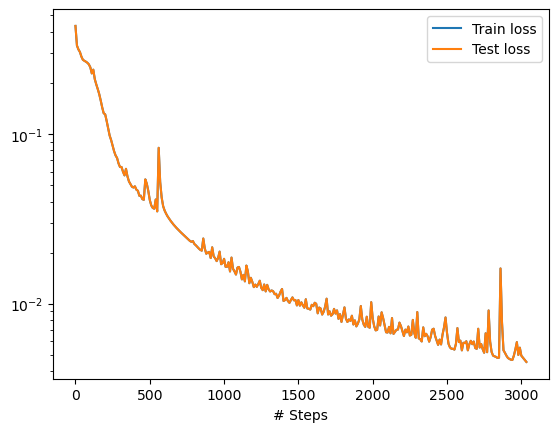

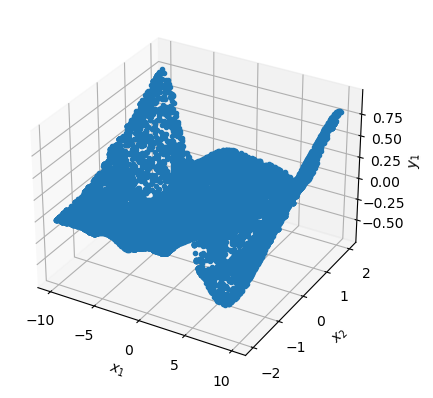

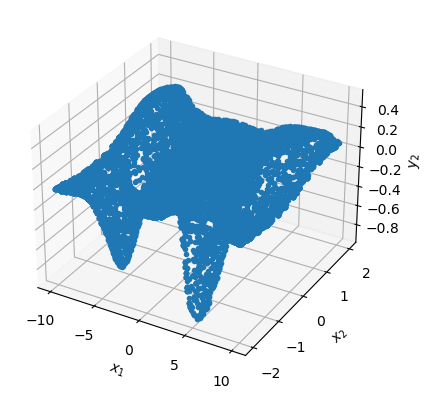

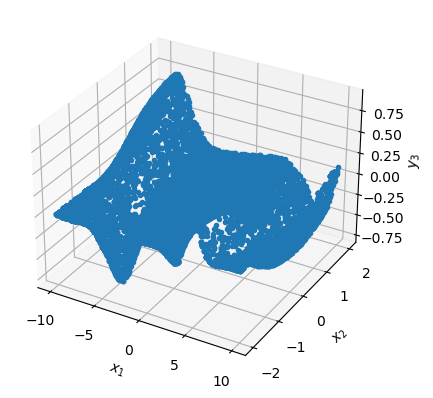

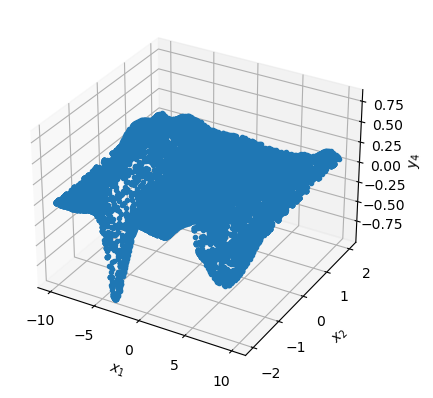

In [15]:
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=3000,
    maxfun=5000,
    maxls=50,
)
model.compile("L-BFGS")
#model.train()

losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

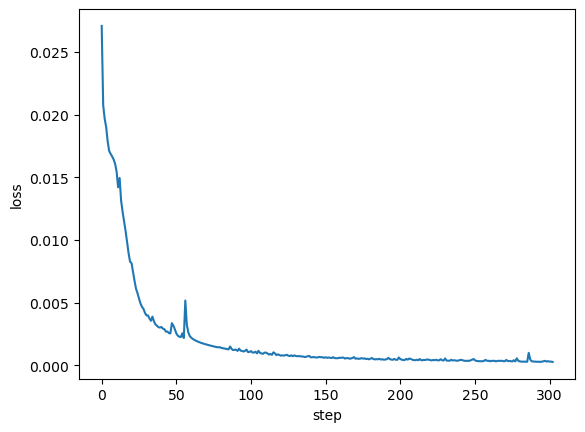

In [16]:

loss_t = losshistory.loss_train



plt.plot(np.mean(loss_t,axis=1))
plt.xlabel("step")
plt.ylabel("loss")

print(losshistory)
print(train_state)

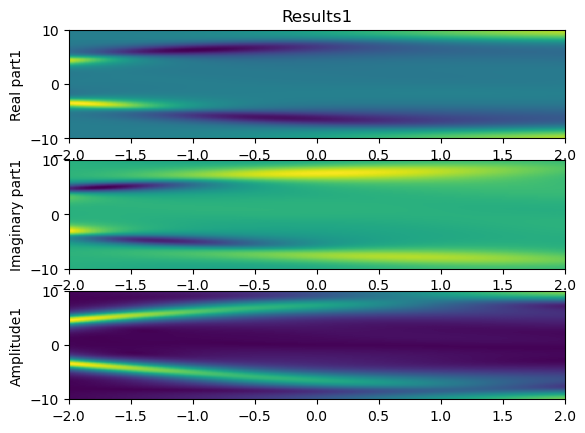

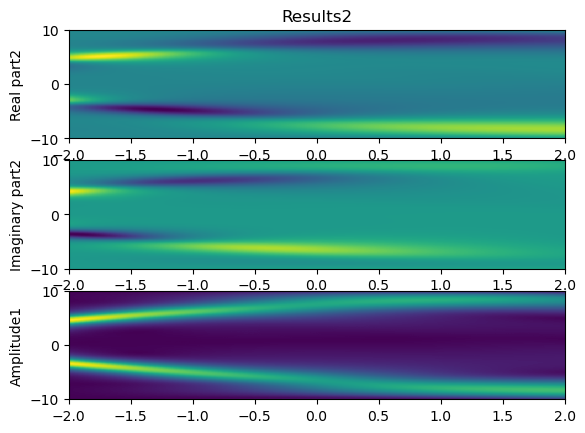

In [17]:
# 做预测
prediction = model.predict(X_star, operator=None)

u1 = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v1 = griddata(X_star, prediction[:, 1], (X, T), method="cubic")
u2 = griddata(X_star, prediction[:, 2], (X, T), method="cubic")
v2 = griddata(X_star, prediction[:, 3], (X, T), method="cubic")


h1 = np.sqrt(u1 ** 2 + v1 ** 2)
h2=np.sqrt(u2**2+v2**2)



# 绘制预测
fig, ax = plt.subplots(3)

ax[0].set_title("Results1")
ax[0].set_ylabel("Real part1")
ax[0].imshow(
    u1.T,
    interpolation="nearest", #插值
    cmap="viridis", #色彩图
    extent=[t_lower, t_upper, x_lower, x_upper], #极值
    origin="lower",
    aspect="auto",
)
ax[1].set_ylabel("Imaginary part1")
ax[1].imshow(
    v1.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
ax[2].set_ylabel("Amplitude1")
ax[2].imshow(
    h1.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)

fig, bx = plt.subplots(3)
bx[0].set_title("Results2")
bx[0].set_ylabel("Real part2")
bx[0].imshow(
    u2.T,
    interpolation="nearest", #插值
    cmap="viridis", #色彩图
    extent=[t_lower, t_upper, x_lower, x_upper], #极值
    origin="lower",
    aspect="auto",
)
bx[1].set_ylabel("Imaginary part2")
bx[1].imshow(
    v2.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
bx[2].set_ylabel("Amplitude1")
bx[2].imshow(
    h2.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_lower, x_upper],
    origin="lower",
    aspect="auto",
)
plt.show()

[   34451    38260    38073 ... 91561632 90838304 89952320]


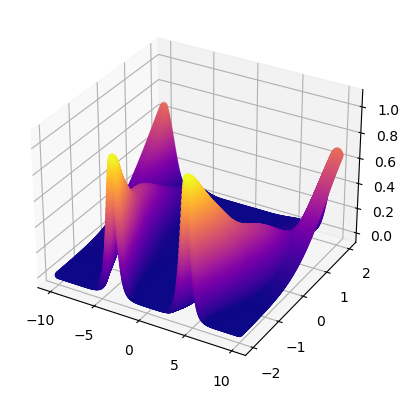

In [18]:
ax = plt.axes(projection='3d')


b=prediction[:,0]**2+prediction[:,1]**2
c=min(b)
d=b/c
d=d.astype(int)
print(d)
# Data for a three-dimensional line
ax.scatter3D(X_star[:,0],X_star[:,1],b,c=d[:],cmap='plasma')

[   3053    2623    2291 ... 1440656 1794610 2218262]
(402, 512)
(402, 512)
(205824, 2)
(205824, 4)


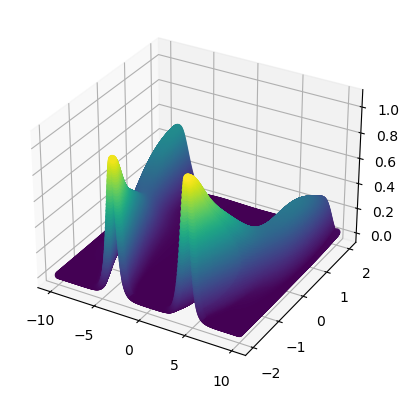

In [19]:
bx = plt.axes(projection='3d')
b=prediction[:,2]**2+prediction[:,3]**2
c=min(b)
d=b/c
d=d.astype(int)
print(d)
bx.scatter3D(X_star[:,0],X_star[:,1],b,c=d[:]/10)

print(X.shape)
print(T.shape)
print(X_star.shape)
print(prediction.shape)

In [20]:
print(c)

1.4093882e-08


In [21]:
b=1
c=2
a=complex(b,c)
print(a)

(1+2j)


In [22]:
z=-1j
print(z)

(-0-1j)


In [23]:
print(z.imag)

-1.0
